# Dielectric properties of Si

We start by computing the high-frequency dielectric tensor of silicon using `aiida-vibroscopy`.

In this tutorial we will make use of the silicon structure to give you an overall understanding of the usage of the package.

Let's get started!


## Finite electric fields

In the harmonic and Born-Oppenheimer approximation, the high-frequency dielectric tensor is defined as second order derivative of the polarization of the system in respect to an external electric field $\mathcal{E}$.
The polarization $\mathbf{P}$ is computed via the modern theory of polarization, using a Berry phase formalism. An external electric field can still be applied, even though the Hamiltonian will result not bounded from below, and translational symmetry is broken (hence, in principle no Bloch's theorem).

::: {note}
All these difficulties were solved in the early 2000s. See:

- Ivo Souza, Jorge Iniguez, and David Vanderbilt, Phys. Rev. Lett, __89__, 117602 (__2002__)
- Paolo Umari and Alfredo Pasquarello, Phys. Rev. Lett, __89__, 157602 (__2002__)
:::

Extending the Kohn-Sham Hamiltonian, we can include the external electric field as follows:

\begin{equation}
    \mathcal{F}[\{ \psi \}] 
    =
    E_{KS}[\rho]
    - \Omega \mathbf{P}[\{ \psi \}] \cdot \mathcal{E}
\end{equation}

This extended functional is usually referred to as __electric enthalpy functional__.

One subtlelty of this formalism is the slow convergence is respect to k points. In particular, to converge well the polarization operator, one has to sample with many k points the direction of the induced polarization (i.e. the direction of the applied electric field).

In the following workflows, we will define the amount of k point in this direction through what we call __parallel distance__ between k points. This distance is used to define the number of k points. The smaller it is, the more points will be defined, hence more accurate results.

The high-frequency dielectric tensor is computed like frozen phonons: forces become the polarization, atomic displacements become the electric field step. In the {{ dielwc }}, this step can either be automatically chosen or set manually.

::: {important}
It is fundamental that the electric field step is properly chosen. In fact, only values below the __critical electric field__ $\mathcal{E}_c$ can be chosen. An estimate of such value can be done knowing the amount of k points and the band gap of the material. 

\begin{equation}
    \mathcal{E}_c \approx \frac{E_{gap} }{e \cdot a \cdot N_k }
\end{equation}

Thus, increasing the number of k points signifies a lower critical field, hence we are allowed to use smaller field steps. As a consequence, trade off with convergence must be made. Nevertheless, for the majority of cases this does not represent a limitation.
:::

In [1]:
from local_module import load_temp_profile

# If you download this file, you can run it with your own profile.
# Put these lines instead:
# from aiida import load_profile
# load_profile()
data = load_temp_profile(
    name="dielectric-tutorial",
    add_computer=True,
    add_pw_code=True,
    add_sssp=True,
)

/opt/conda/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,



## The `DielectricWorkChain`

As for phonons, we need to compute different ground-states with different displacements, in this case different directions of the electric field. We can use the {{ dielwc }} to do this in automated fashion.

:::{note}
:class: dropdown

As again for phonons, also the dielectric properties can be computed in the _linear regime_ as perturbative respones of the system. Quantum ESPRESSO can carry out such simulation using the __PHonon__ code (`ph.x` routine). Nevertheless, not all functionals are implemented. For example, DFT+U(+V) using ortho-atomic projectors is not implemented.
:::

Let's import the WorkChain and run it! We use the `get_builder_from_protocol` to get a __prefilled__ builder with __all inputs__. 

::: {note}
These inputs should be considered __not as converged parameters__, but as a good starting point. You may also need to tweak some parameters, e.g. add magnetization etc., depending on your case. 
:::

In [2]:
from aiida.plugins import DbImporterFactory

CodDbImporter = DbImporterFactory('cod')

cod = CodDbImporter()
results = cod.query(id='1526655') # Si   1526655
structure = results[0].get_aiida_structure() # it has 8 atoms

In [3]:
from aiida.plugins import WorkflowFactory
from aiida.engine import run_get_node

DielectricWorkChain = WorkflowFactory("vibroscopy.dielectric")

builder = DielectricWorkChain.get_builder_from_protocol(
    code=data.pw_code,
    structure=structure,
    protocol="fast",
    overrides={"property":"dielectric"}
)

results, calc = run_get_node(builder)

08/25/2023 10:00:55 PM <1021007> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [98|DielectricWorkChain|run_base_scf]: launching base scf PwBaseWorkChain<106>
08/25/2023 10:00:56 PM <1021007> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [106|PwBaseWorkChain|run_process]: launching PwCalculation<109> iteration #1
08/25/2023 10:01:03 PM <1021007> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [106|PwBaseWorkChain|sanity_check_insufficient_bands]: PwCalculation<109> run with smearing and highest band is occupied
08/25/2023 10:01:03 PM <1021007> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [106|PwBaseWorkChain|sanity_check_insufficient_bands]: BandsData<112> has invalid occupations: Occupation of 0.009307178053852729 at last band lkn<0,0,20>
08/25/2023 10:01:03 PM <1021007> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [106|PwBaseWorkChain|sanity_check_insufficient_bands]: PwCalculation

These are the results:

In [4]:
results

{'critical_electric_field': <Float: uuid: c3a00ae5-2925-4f55-92f6-89718ce46f00 (pk: 135) value: 0.00091230365735815>,
 'electric_field_step': <Float: uuid: 31b2a2dd-77a4-4c17-9a6b-42c0b4c015fc (pk: 139) value: 0.00045615182867907>,
 'fields_data': {'field_index_2': {'0': <TrajectoryData: uuid: 0d5b1d5e-963e-47c8-9661-8dbbe6a8215a (pk: 160)>,
   '1': <TrajectoryData: uuid: 9e5998b7-9bf5-4f25-b4f2-10b2aeda1b79 (pk: 171)>}},
 'tensors': AttributeDict({'numerical_accuracy_2_step_2': <ArrayData: uuid: f5b2f505-aa7f-4223-ae46-557d5d3b284d (pk: 182)>, 'numerical_accuracy_2_step_1': <ArrayData: uuid: cb05c62b-de1f-45e1-ad74-f5a0af287cfc (pk: 183)>, 'numerical_accuracy_4': <ArrayData: uuid: 80e7fff4-5957-431e-b2c4-52f45a9a8d06 (pk: 184)>})}

As you can see, we have a __tensors__ output. This is a _namespace_, meaning it contains more outputs. If we inspect it, we can see we have some other names, all starting with `numerical_accuracy_*`. This is because the workflow decided to use __more points__ (electric field steps) to have a better accuracy for the numerical differentiation. In this case, up to the 4th order accuracy is given, using the following formula:

\begin{equation}
    \left . \frac{\partial f(x)}{\partial x} \right|_{x=0}
    =
    \frac{1}{12 h}
    \left [
        -f(2h) +8f(h) -8f(-h) +f(-2h)
    \right ]
    + \mathcal{O}(h^4)
\end{equation}

$f(h)$ will then be $\mathbf{P}(\delta \mathbf(E))$, a three variable function computing three dimensional output; hence, we will get a matrix out of the differentiation. This expression goes as $\mathcal{O}(h^4)$, meaning the numerical error due to the finite step will be _much smaller_ then with a second order formula. 

::: {important}
Having computed the 4th order accuracy, one can compute also the 2nd order accuracy with the two external and two internal points!

Have a look at the [finite difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient) to convince yourself.

This is extremely useful, as __one can check a posteriori__ the convergence in respect to finite size step.
:::

Let's print the results!

In [5]:
print("Numerical accuracy order 4:")
print(calc.outputs.tensors.numerical_accuracy_4.get_array("dielectric").round(5), "\n")
print("Numerical accuracy order 2 (inner points):")
print(calc.outputs.tensors.numerical_accuracy_2_step_1.get_array("dielectric").round(5), "\n")
print("Numerical accuracy order 2 (external points):")
print(calc.outputs.tensors.numerical_accuracy_2_step_2.get_array("dielectric").round(5))

Numerical accuracy order 4:
[[11.08481 -0.       0.     ]
 [ 0.      11.08481 -0.     ]
 [-0.      -0.      11.08481]] 

Numerical accuracy order 2 (inner points):
[[11.08522 -0.       0.     ]
 [ 0.      11.08522  0.     ]
 [-0.      -0.      11.08522]] 

Numerical accuracy order 2 (external points):
[[11.08645 -0.       0.     ]
 [ 0.      11.08645  0.     ]
 [-0.       0.      11.08645]]


We can conclude the 2nd order accuracy is accurate till the third digit, much more accurate then the convergence error!

In [6]:
print("The estimated critical electric field step: ", calc.outputs.critical_electric_field.value)
print("The electric field step: ", calc.outputs.electric_field_step.value)

The estimated critical electric field step:  0.00091230365735815
The electric field step:  0.00045615182867907


## Analysing the workflow

Many things happened for computing this dielectric tensor. Let's inspect the process tree.

In [7]:
%verdi process status {calc.pk}

DielectricWorkChain<98> Finished [0] [11:results]
    ├── create_kpoints_from_distance<99> Finished [0]
    ├── create_directional_kpoints<102> Finished [0]
    ├── PwBaseWorkChain<106> Finished [0] [3:results]
    │   ├── PwCalculation<109> Finished [0]
    │   └── PwCalculation<117> Finished [0]
    ├── PwBaseWorkChain<125> Finished [0] [3:results]
    │   └── PwCalculation<128> Finished [0]
    ├── compute_critical_electric_field<134> Finished [0]
    ├── get_accuracy_from_critical_field<136> Finished [0]
    ├── get_electric_field_step<138> Finished [0]
    ├── PwBaseWorkChain<142> Finished [0] [3:results]
    │   └── PwCalculation<145> Finished [0]
    ├── PwBaseWorkChain<153> Finished [0] [3:results]
    │   └── PwCalculation<156> Finished [0]
    ├── PwBaseWorkChain<164> Finished [0] [3:results]
    │   └── PwCalculation<167> Finished [0]
    ├── subtract_residual_forces<175> Finished [0]
    └── NumericalDerivativesWorkChain<178> Finished [0] [None]
        ├── generate_preproc

Here the explanation:

1. The k points grids for SCF and electric field are generated.
2. A _base_ ground-state calculation is performed via a {{ pwbase }}. This will be used in the following as _starting point_ for all the electric field steps.
3. An NSCF is performed to evaluate the band gap of the material.
4. The _critical electric field_ is evaluated.
5. From this estimate, the numerical accuracy (i.e. number of points) and the electric field step are extrapolated. The accuracy is 4, the value of the field is $\approx 5\cdot 10^{-4}$ Ry atomic units (1 Ry a.u. $\approx$ $36.3609 \cdot 10^{10}$ V/m).
6. A ground-state elecrtric field with $\mathcal{E}=0$ is performed for each inequivalent k point grid.
7. Once finished, SCF with electric field $\mathcal{E}=\delta \mathbf{E}$ are run, restarting from the previous calculations.
8. Once finished, SCF with electric field $\mathcal{E}=2 \delta \mathbf{E}$ are run, restarting from the previous calculations.
9. The numerical derivatives are performed, and tensors are stored.

::: {admonition} Can you explain why only one direction?
:class: hint, dropdown

We used symmetries to reduce the number of directions to compute. In materials, we can exploit the fact that different operations are connected by symmetry. As an example, if we have inversion symmetry, it holds (for a one dimensional function):

\begin{equation}
 f(x) = -f(-x)
\end{equation}

Thus, we would save one calculation. In silicon, we have only one symmetrically inequivalent direction, thanks to its very symmetric point group. The power of symmetries!
:::

You can also inspect this data to convince yourself.

In [8]:
calc.outputs.fields_data

AttributeDict({'field_index_2': AttributeDict({'0': <TrajectoryData: uuid: 0d5b1d5e-963e-47c8-9661-8dbbe6a8215a (pk: 160)>, '1': <TrajectoryData: uuid: 9e5998b7-9bf5-4f25-b4f2-10b2aeda1b79 (pk: 171)>})})

## Born effective charges

With this method, we can also compute the Born effective charges $Z^*$. They are the derivatives of the forces in respect to electric fields, in contrast with the polarization for the dielectric tensor. In the case of silicon, as this is a homopolar material, they will be _zero_, as you can verify. In the tutorial on AlAs, you will calculate non zero BEC!

In [9]:
calc.outputs.tensors.numerical_accuracy_4.get_array("born_charges").round(5)

array([[[ 0., -0.,  0.],
        [-0.,  0.,  0.],
        [ 0., -0.,  0.]],

       [[-0., -0.,  0.],
        [-0., -0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0., -0.],
        [-0.,  0., -0.],
        [-0.,  0., -0.]],

       [[-0., -0., -0.],
        [ 0., -0.,  0.],
        [-0.,  0., -0.]],

       [[-0., -0.,  0.],
        [ 0., -0.,  0.],
        [-0., -0.,  0.]],

       [[-0.,  0., -0.],
        [-0.,  0., -0.],
        [-0., -0., -0.]],

       [[-0.,  0., -0.],
        [ 0.,  0., -0.],
        [-0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0., -0., -0.],
        [-0., -0.,  0.]]])

## Convergence with k points

As a final remark, we show here how the convergence with k points is speeded up by sampling in this _directional_ manner, compared to the most 'traditional' uniform mesh. 

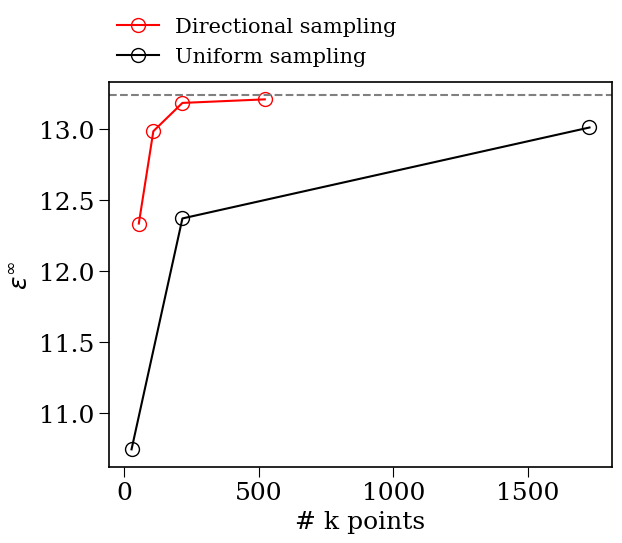

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Some options to make the plot nice
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = "serif"
plt.rcParams['text.usetex'] = False
plt.rcParams['xtick.major.size'] = 7.0
plt.rcParams['xtick.minor.size'] = 4.
plt.rcParams['ytick.major.size'] = 7.0
plt.rcParams['ytick.minor.size'] = 4.
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['legend.fontsize'] = 15

# Directional sampling
diel_new = np.array([12.333, 12.983, 13.182, 13.207])
kpoints_new = np.array([3*3*6, 3*3*12, 3*3*24, 3*3*58])

# Uniform sampling
diel = np.array([10.744, 12.369, 13.009])
kpoints = np.array([3*3*3, 6*6*6, 12*12*12])

# Plotting
fig, ax = plt.subplots(figsize=(6.5,5)) # dichiaro il canvas e i subplots    

ax.plot(kpoints_new, diel_new, color='red', marker='o', fillstyle='none', ms=10, linewidth=1.5, linestyle='-', label='Directional sampling')  
ax.plot(kpoints, diel, color='black', marker='o', fillstyle='none', ms=10, linewidth=1.5, linestyle='-', label='Uniform sampling')  
ax.set_xlabel('# k points')  
ax.set_ylabel(r'$\epsilon^{\infty}$')
ax.axhline(13.241, color='grey', linestyle='--', linewidth=1.5)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0., frameon=False)

# plt.show()